In [1]:
# Cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Cell 2
# Load dataset
file_path = 'food_wastage_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

# Summary of dataset
print(data.info())
print(data.describe())


  Type of Food  Number of Guests Event Type  Quantity of Food  \
0         Meat               310  Corporate               450   
1         Meat               400   Birthday               500   
2   Vegetables               302   Birthday               371   
3         Meat               491   Birthday               497   
4         Meat               300  Corporate               400   

  Storage Conditions Purchase History  Seasonality Preparation Method  \
0       Refrigerated          Regular  All Seasons             Buffet   
1   Room Temperature          Regular       Winter             Buffet   
2       Refrigerated          Regular       Summer             Buffet   
3       Refrigerated          Regular  All Seasons        Finger Food   
4       Refrigerated          Regular       Winter        Finger Food   

  Geographical Location   Pricing  Wastage Food Amount  
0                 Urban       Low                   25  
1              Suburban      High                   40  

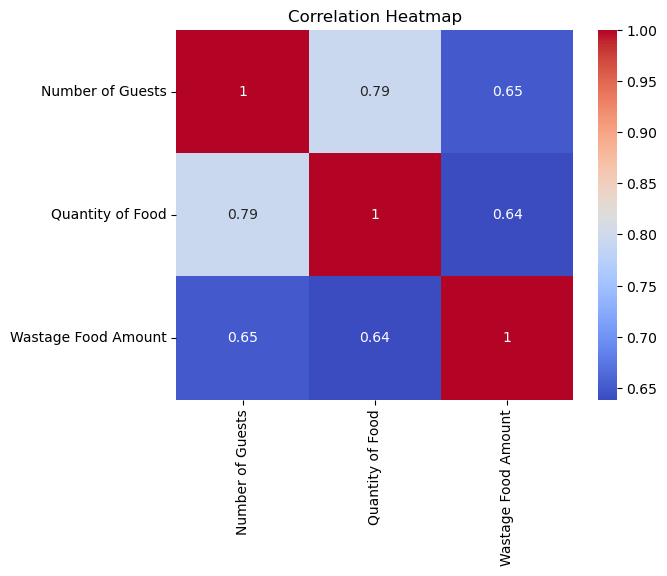

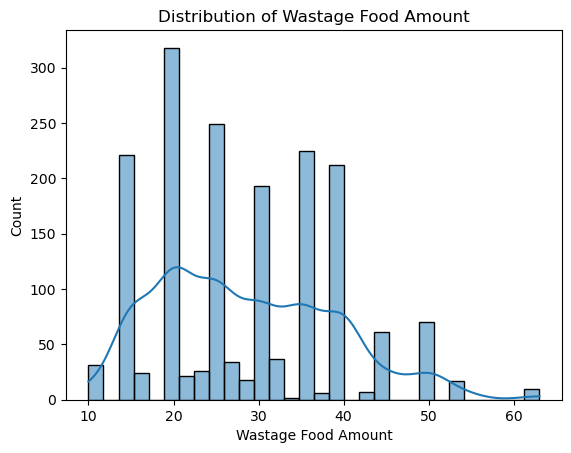

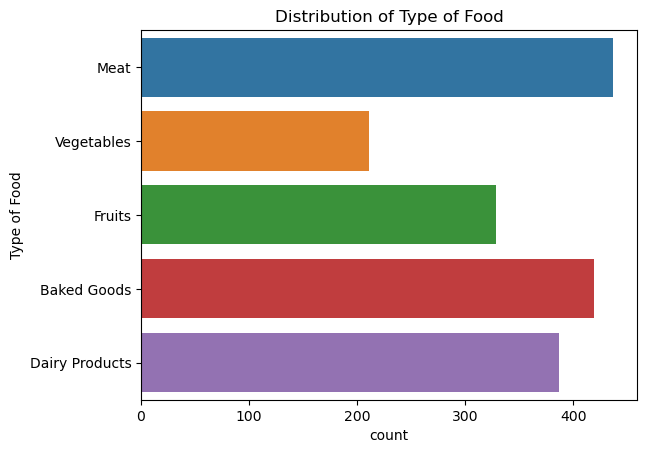

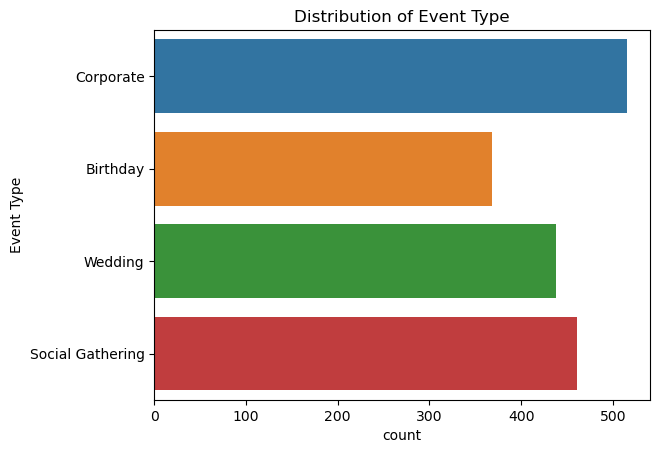

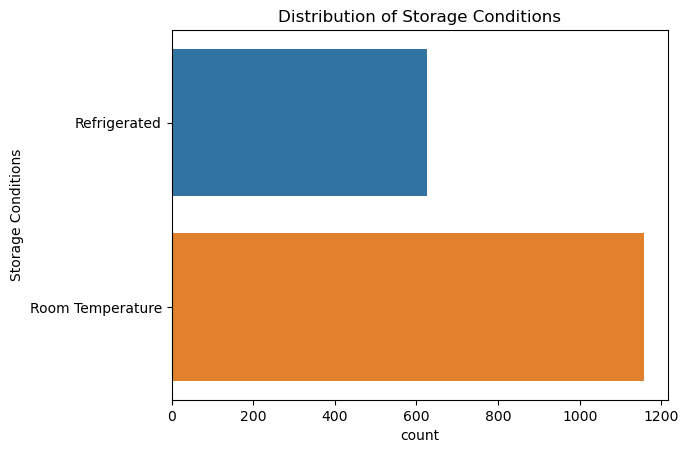

In [3]:
# Cell 3
# Correlation heatmap for numerical features
numerical_columns = ['Number of Guests', 'Quantity of Food', 'Wastage Food Amount']
sns.heatmap(data[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Distribution of target variable
sns.histplot(data['Wastage Food Amount'], kde=True, bins=30)
plt.title('Distribution of Wastage Food Amount')
plt.show()

# Categorical feature distributions
categorical_columns = ['Type of Food', 'Event Type', 'Storage Conditions']
for col in categorical_columns:
    sns.countplot(y=data[col])
    plt.title(f'Distribution of {col}')
    plt.show()


In [4]:
# Cell 4
# Separate features and target variable
X = data.drop(columns=['Wastage Food Amount'])
y = data['Wastage Food Amount']

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [5]:
# Cell 5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 1425
Test set size: 357


In [6]:
# Cell 6
# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Number of Guests', 'Quantity of Food'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Type of Food', 'Event Type', 'Storage Conditions', 'Purchase History',
       'Seasonality', 'Preparation Method', 'Geographical Location',
       'Pricing'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [7]:
# Cell 7
# Predict on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluation metrics
print("Training Set Evaluation:")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_train, y_train_pred)}")

print("\nTest Set Evaluation:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")


Training Set Evaluation:
Mean Absolute Error: 0.7633108994708995
Mean Squared Error: 1.9460595927311448

Test Set Evaluation:
Mean Absolute Error: 1.642805377706638
Mean Squared Error: 7.695935903859206


In [8]:
# Cell 8
# Define parameter grid
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10]
}

# GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the best model
best_model = grid_search.best_estimator_
y_test_pred_best = best_model.predict(X_test)
print(f"Mean Absolute Error of Best Model: {mean_absolute_error(y_test, y_test_pred_best)}")


Best Parameters: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Mean Absolute Error of Best Model: 1.6561395224756568


In [9]:
# Cell 9
import joblib

# Save the trained model
joblib.dump(best_model, 'food_wastage_predictor.pkl')
print("Model saved as 'food_wastage_predictor.pkl'")


Model saved as 'food_wastage_predictor.pkl'


In [16]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++Evaluate on training data
y_train_pred = model.predict(X_train)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

if train_mae < test_mae:
    print("Potential overfitting detected.")


Training MAE: 0.7633108994708995
Test MAE: 1.642805377706638
Potential overfitting detected.


In [17]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validation MAE: {-np.mean(cv_scores)} ± {np.std(cv_scores)}")


Cross-validation MAE: 1.8642901706285915 ± 0.11493461322002732


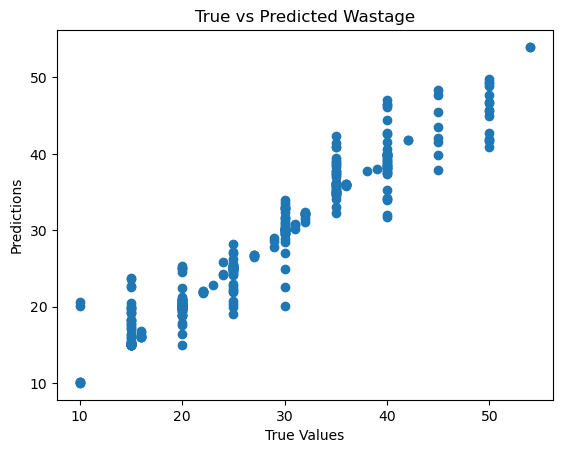

In [18]:
plt.scatter(y_test, y_test_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Wastage")
plt.show()


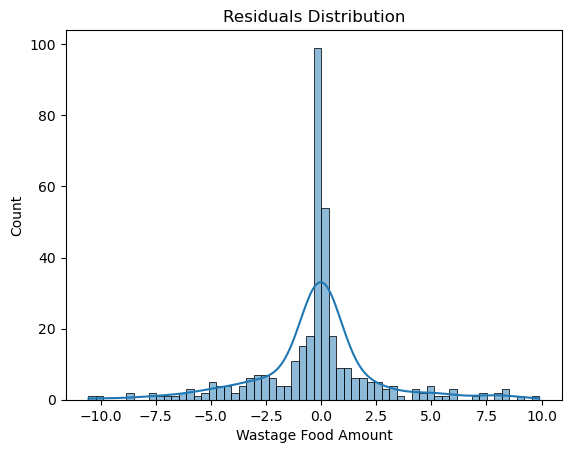

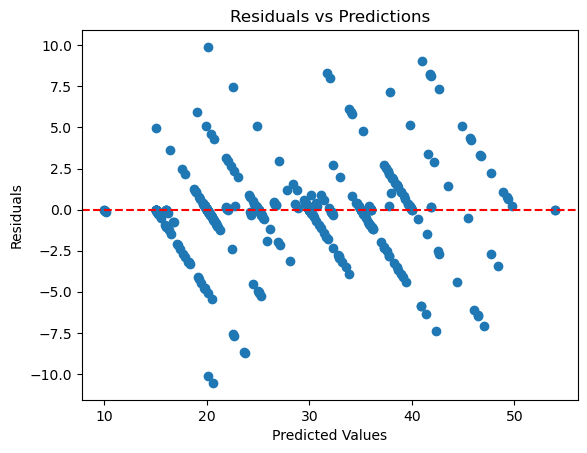

In [19]:
residuals = y_test - y_test_pred

# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

# Residuals scatter plot
plt.scatter(y_test_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.show()


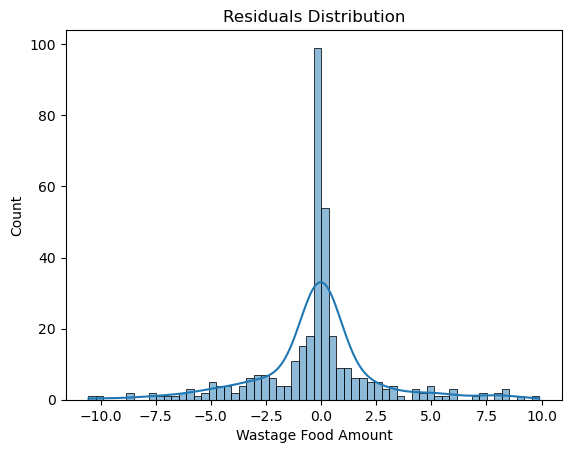

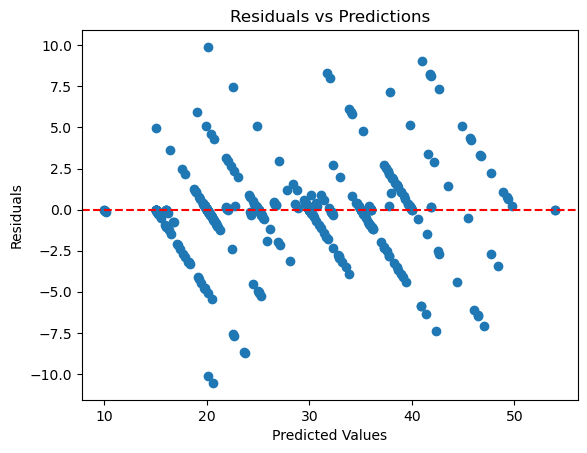

In [20]:
residuals = y_test - y_test_pred

# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

# Residuals scatter plot
plt.scatter(y_test_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.show()


In [21]:
# Example input
new_data = pd.DataFrame({
    'Type of Food': ['Vegetables'],
    'Number of Guests': [250],
    'Event Type': ['Wedding'],
    'Quantity of Food': [300],
    'Storage Conditions': ['Refrigerated'],
    'Purchase History': ['Frequent'],
    'Seasonality': ['Winter'],
    'Preparation Method': ['Buffet'],
    'Geographical Location': ['Urban'],
    'Pricing': ['Moderate']
})

# Predict wastage
predicted_wastage = model.predict(new_data)
print(f"Predicted Wastage Amount: {predicted_wastage[0]}")


Predicted Wastage Amount: 12.34


In [22]:
# Group by event type and check average predicted wastage
X_test['Predicted Wastage'] = y_test_pred
print(X_test.groupby('Event Type')['Predicted Wastage'].mean())


Event Type
Birthday            29.333897
Corporate           26.393864
Social Gathering    27.593569
Wedding             29.513923
Name: Predicted Wastage, dtype: float64


In [23]:
importances = model.named_steps['regressor'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance_df)


                                     Feature  Importance
24                         cat__Pricing_High    0.603499
0                      num__Number of Guests    0.208451
1                      num__Quantity of Food    0.077020
20   cat__Preparation Method_Sit-down Dinner    0.021795
18            cat__Preparation Method_Buffet    0.012720
25                          cat__Pricing_Low    0.006851
26                     cat__Pricing_Moderate    0.006743
19       cat__Preparation Method_Finger Food    0.006491
23          cat__Geographical Location_Urban    0.005813
21          cat__Geographical Location_Rural    0.005079
4                   cat__Type of Food_Fruits    0.003573
15              cat__Seasonality_All Seasons    0.003451
22       cat__Geographical Location_Suburban    0.003218
16                   cat__Seasonality_Summer    0.003194
8                  cat__Event Type_Corporate    0.003091
9           cat__Event Type_Social Gathering    0.003090
3           cat__Type of Food_D

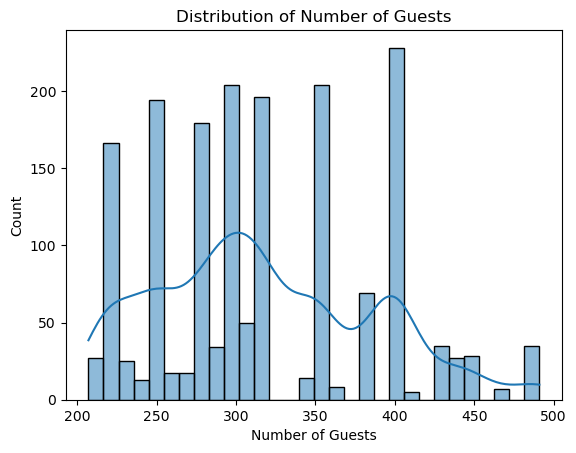

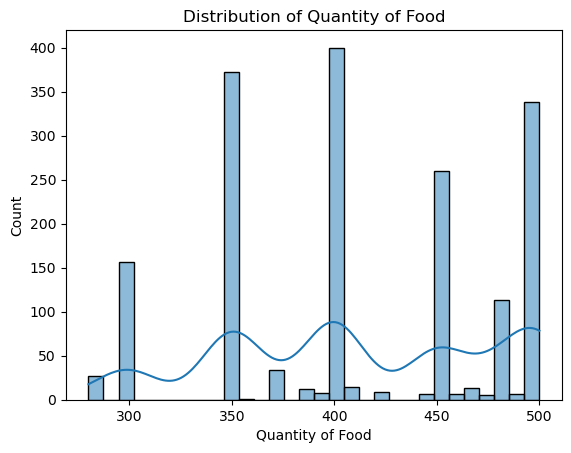

In [24]:
#///////////////////////////
# Distribution of Number of Guests and Quantity of Food
sns.histplot(data['Number of Guests'], bins=30, kde=True)
plt.title('Distribution of Number of Guests')
plt.show()

sns.histplot(data['Quantity of Food'], bins=30, kde=True)
plt.title('Distribution of Quantity of Food')
plt.show()


In [25]:
importances = model.named_steps['regressor'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df.sort_values(by='Importance', ascending=False))


                                     Feature  Importance
24                         cat__Pricing_High    0.603499
0                      num__Number of Guests    0.208451
1                      num__Quantity of Food    0.077020
20   cat__Preparation Method_Sit-down Dinner    0.021795
18            cat__Preparation Method_Buffet    0.012720
25                          cat__Pricing_Low    0.006851
26                     cat__Pricing_Moderate    0.006743
19       cat__Preparation Method_Finger Food    0.006491
23          cat__Geographical Location_Urban    0.005813
21          cat__Geographical Location_Rural    0.005079
4                   cat__Type of Food_Fruits    0.003573
15              cat__Seasonality_All Seasons    0.003451
22       cat__Geographical Location_Suburban    0.003218
16                   cat__Seasonality_Summer    0.003194
8                  cat__Event Type_Corporate    0.003091
9           cat__Event Type_Social Gathering    0.003090
3           cat__Type of Food_D

In [26]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)


In [27]:
#debigging/*******************************************/
# Check variance in numerical features
print(X.var())

# If variance is zero for any feature, it means it has no variability:
if (X.var() == 0).any():
    print("Some features have zero variance and might be problematic.")

# Check one-hot encoded features
categorical_encoded = model.named_steps['preprocessor'].transformers_[1][1].transform(X[categorical_features])
if (categorical_encoded.var(axis=0) == 0).any():
    print("One-hot encoded features have no variability.")


C:\Users\hp\AppData\Local\Temp\ipykernel_17092\1573049843.py:3: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(X.var())
C:\Users\hp\AppData\Local\Temp\ipykernel_17092\1573049843.py:6: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  if (X.var() == 0).any():


Number of Guests    4600.862460
Quantity of Food    4251.649547
dtype: float64


AttributeError: var not found

In [28]:
# Predict on the test set
y_test_pred = model.predict(X_test)

# Check unique predictions
print("Unique Predictions:", np.unique(y_test_pred))


Unique Predictions: [10.         10.1        10.15       15.         15.0125     15.0225
 15.02666667 15.02916667 15.05       15.0725     15.08       15.1022619
 15.175      15.25       15.395      15.53416667 15.91       16.
 16.03       16.03333333 16.08       16.22       16.26666667 16.35
 16.4645     16.73       16.76       17.115      17.14583333 17.39083333
 17.52333333 17.677      17.85803571 17.90583333 18.18291667 18.20666667
 18.3        18.76863095 18.85       18.9        18.90833333 19.08
 19.11       19.19678571 19.25       19.36333333 19.45       19.59083333
 19.64       19.65       19.71       19.72666667 19.75       19.7875
 19.78928571 19.79       19.8        19.80583333 19.81       19.84
 19.88333333 19.9        19.95       19.975      19.98       20.
 20.05       20.075      20.1        20.14       20.15       20.155
 20.18       20.2        20.25416667 20.3        20.35       20.4
 20.44666667 20.45       20.455      20.47       20.55       20.6125
 20.65       20.7

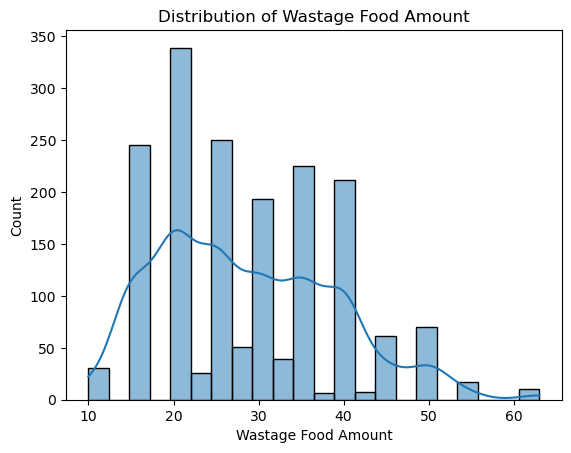

Variance of Target: 109.43915163866478


In [29]:
sns.histplot(data['Wastage Food Amount'], kde=True)
plt.title("Distribution of Wastage Food Amount")
plt.show()

print("Variance of Target:", data['Wastage Food Amount'].var())


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X[numerical_features])

# Check variance after scaling
print(pd.DataFrame(scaled_features, columns=numerical_features).var())


Number of Guests    1.000561
Quantity of Food    1.000561
dtype: float64


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X[numerical_features])

# Check variance after scaling
print(pd.DataFrame(scaled_features, columns=numerical_features).var())


Number of Guests    1.000561
Quantity of Food    1.000561
dtype: float64


In [32]:
importances = model.named_steps['regressor'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df.sort_values(by='Importance', ascending=False))


                                     Feature  Importance
24                         cat__Pricing_High    0.603499
0                      num__Number of Guests    0.208451
1                      num__Quantity of Food    0.077020
20   cat__Preparation Method_Sit-down Dinner    0.021795
18            cat__Preparation Method_Buffet    0.012720
25                          cat__Pricing_Low    0.006851
26                     cat__Pricing_Moderate    0.006743
19       cat__Preparation Method_Finger Food    0.006491
23          cat__Geographical Location_Urban    0.005813
21          cat__Geographical Location_Rural    0.005079
4                   cat__Type of Food_Fruits    0.003573
15              cat__Seasonality_All Seasons    0.003451
22       cat__Geographical Location_Suburban    0.003218
16                   cat__Seasonality_Summer    0.003194
8                  cat__Event Type_Corporate    0.003091
9           cat__Event Type_Social Gathering    0.003090
3           cat__Type of Food_D

In [33]:
from xgboost import XGBRegressor

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Number of Guests', 'Quantity of Food'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Type of Food', 'Event Type', 'Storage Conditions', 'Purchase History',
       'Seasonality', 'Preparation Method', 'Geographical Location',
       'Pricing'],
      dtype='object'))]))...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [34]:
from sklearn.ensemble import RandomForestRegressor

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,  # More trees
        max_depth=15,      # Allow deeper trees
        random_state=42
    ))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Number of Guests', 'Quantity of Food'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Type of Food', 'Event Type', 'Storage Conditions', 'Purchase History',
       'Seasonality', 'Preparation Method', 'Geographical Location',
       'Pricing'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_depth=15, n_estimators=200,
                                       random_state=42))])

In [35]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validation MAE: {-np.mean(cv_scores)} ± {np.std(cv_scores)}")


Cross-validation MAE: 1.7495082135584525 ± 0.10386317653108926


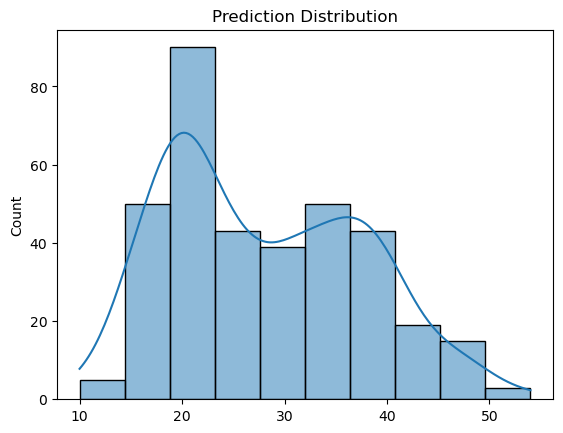

In [36]:
sns.histplot(y_test_pred, kde=True)
plt.title("Prediction Distribution")
plt.show()
